In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_mnist():
    # 加载 MNIST 数据集
    train_images = idx2numpy.convert_from_file(r"..\train-images.idx3-ubyte")
    train_labels = idx2numpy.convert_from_file(r"..\train-labels.idx1-ubyte")
    test_images = idx2numpy.convert_from_file(r"..\t10k-images.idx3-ubyte")
    test_labels = idx2numpy.convert_from_file(r"..\t10k-labels.idx1-ubyte")

    # 将图像数据转换为一维数组并归一化
    train_images = train_images.reshape((train_images.shape[0], -1)).astype('float32') / 255
    test_images = test_images.reshape((test_images.shape[0], -1)).astype('float32') / 255

    # 将标签转换为 one-hot 编码
    train_labels = one_hot_encode(train_labels)
    test_labels = one_hot_encode(test_labels)

    return train_images, train_labels, test_images, test_labels

def plot_accuracy(train_acc, test_acc):
    # 绘制训练准确率和测试准确率的图
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def one_hot_encode(labels, num_classes=10):
    # 将类别标签转换为 one-hot 编码格式
    one_hot_labels = np.zeros((labels.shape[0], num_classes))
    one_hot_labels[np.arange(labels.shape[0]), labels] = 1
    return one_hot_labels

In [3]:

class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # 初始化Adam优化器的参数
        self.learning_rate = learning_rate  # 设置学习率
        self.beta1 = beta1  # 设置一阶矩估计（momentum）的衰减率
        self.beta2 = beta2  # 设置二阶矩估计（RMSprop）的衰减率
        self.epsilon = epsilon  # 防止除以零的小常数
        self.t = 0  # 初始化时间步，用于偏差校正

    def update_parameters(self, nn, gradients_w, gradients_b):
        # 更新神经网络的参数
        if not hasattr(self, 'm_w'):
            # 如果moment向量还没有初始化，则进行初始化
            self.m_w = [np.zeros_like(w) for w in nn.weights]  # 初始化权重的一阶矩估计
            self.v_w = [np.zeros_like(w) for w in nn.weights]  # 初始化权重的二阶矩估计
            self.m_b = [np.zeros_like(b) for b in nn.biases]   # 初始化偏置的一阶矩估计
            self.v_b = [np.zeros_like(b) for b in nn.biases]   # 初始化偏置的二阶矩估计

        self.t += 1  # 增加时间步
        correction1 = 1 - self.beta1 ** self.t  # 计算一阶矩估计的偏差校正因子
        correction2 = 1 - self.beta2 ** self.t  # 计算二阶矩估计的偏差校正因子

        for i in range(len(nn.weights)):
            # 遍历神经网络的每一层
            self.m_w[i] *= self.beta1  # 对权重的一阶矩估计应用指数衰减
            self.m_w[i] += (1 - self.beta1) * gradients_w[i]  # 更新权重的一阶矩估计
            self.v_w[i] *= self.beta2  # 对权重的二阶矩估计应用指数衰减
            self.v_w[i] += (1 - self.beta2) * np.square(gradients_w[i])  # 更新权重的二阶矩估计

            m_w_corrected = self.m_w[i] / correction1  # 应用偏差校正到权重的一阶矩估计
            v_w_corrected = self.v_w[i] / correction2  # 应用偏差校正到权重的二阶矩估计

            nn.weights[i] -= self.learning_rate * m_w_corrected / (np.sqrt(v_w_corrected) + self.epsilon)  # 更新权重

            self.m_b[i] *= self.beta1  # 对偏置的一阶矩估计应用指数衰减
            self.m_b[i] += (1 - self.beta1) * gradients_b[i]  # 更新偏置的一阶矩估计
            self.v_b[i] *= self.beta2  # 对偏置的二阶矩估计应用指数衰减
            self.v_b[i] += (1 - self.beta2) * np.square(gradients_b[i])  # 更新偏置的二阶矩估计

            m_b_corrected = self.m_b[i] / correction1  # 应用偏差校正到偏置的一阶矩估计
            v_b_corrected = self.v_b[i] / correction2  # 应用偏差校正到偏置的二阶矩估计

            nn.biases[i] -= self.learning_rate * m_b_corrected / (np.sqrt(v_b_corrected) + self.epsilon)  # 更新偏置


In [4]:
class SimpleNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate, batch_size):
        # 神经网络的构造函数
        np.random.seed(1)  # 设置随机种子以确保结果的可重复性
        # 初始化网络的权重，使用标准正态分布随机生成
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]
        # 初始化网络的偏置，全部设置为零
        self.biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(len(layer_sizes) - 1)]
        # 创建一个 Adam 优化器实例用于训练
        self.optimizer = AdamOptimizer(learning_rate=learning_rate)
        self.batch_size = batch_size

    def sigmoid(self, x):
        # Sigmoid 激活函数
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Sigmoid 函数的导数
        return x * (1 - x)

    def softmax(self, x):
        # Softmax 函数，用于多分类问题的输出层
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止数值溢出
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def fp(self, input):
        # 神经网络的前向传播
        activations = [input]  # 存储每层的激活值
        # 遍历除最后一层外的每一层
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            # 计算下一层的激活值
            activations.append(self.sigmoid(np.dot(activations[-1], w) + b))
        # 计算最后一层的激活值，使用 softmax
        activations.append(self.softmax(np.dot(activations[-1], self.weights[-1]) + self.biases[-1]))
        return activations  # 返回所有层的激活值

    

    def bp(self, x, y):
        # 神经网络的反向传播
        activations = self.fp(x)  # 获取前向传播的结果
        dL_dy = activations[-1] - y  # 计算输出层的误差的偏导数
        gradients_w = []  # 存储权重的梯度
        gradients_b = []  # 存储偏置的梯度

        # 从输出层到输入层反向遍历每一层
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算激活值对加权输入的偏导数
            da_dz = self.sigmoid_derivative(activations[i+1])
            # 应用链式法则更新偏导数
            if i != len(self.weights) - 1:
                dL_dz = dL_dy * da_dz
            else:
                dL_dz = dL_dy  # 对于输出层，偏导数就是dL_dy
            grad_w = activations[i].T.dot(dL_dz)  # 计算权重的梯度
            grad_b = np.sum(dL_dz, axis=0, keepdims=True)  # 计算偏置的梯度
            gradients_w.append(grad_w)  # 添加权重梯度
            gradients_b.append(grad_b)  # 添加偏置梯度
            # 更新偏导数传播到前一层
            if i != 0:
                dL_dy = dL_dz.dot(self.weights[i].T)

        gradients_w.reverse()  # 反转梯度列表
        gradients_b.reverse()  # 反转梯度列表

        # 计算分类正确性
        predictions = self.predict(x)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y, axis=1)
        samples_tf_bp = predicted_classes != true_classes  # 标记分类错误的样本

        return gradients_w, gradients_b, samples_tf_bp  # 返回梯度和分类正确的样本信息


    def train(self, x, y, update_weights=True):
        # 训练神经网络
        losses = []  # 用于存储每批次的损失
        num_batches = x.shape[0] // self.batch_size
        samples_ft = np.ones(x.shape[0], dtype=bool)  # 初始化为所有样本都分类正确

        with tqdm(total=num_batches, desc="Training", unit="batch") as pbar:
            for i in range(0, x.shape[0], self.batch_size):
                x_batch = x[i:i + self.batch_size]  # 获取一批训练数据
                y_batch = y[i:i + self.batch_size]  # 获取一批训练标签
                gradients_w, gradients_b, batch_errors = self.bp(x_batch, y_batch)  # 执行反向传播

                if update_weights:
                    self.optimizer.update_parameters(self, gradients_w, gradients_b)  # 更新权重和偏置

                samples_ft[i:i + self.batch_size] = ~batch_errors  # 更新该批次的样本分类正确性

                y_pred = self.predict(x_batch)  # 进行预测
                loss = self.cross_entropy_loss(y_pred, y_batch)  # 计算损失
                losses.append(loss)  # 添加损失

                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))  # 显示当前批次的损失

        return samples_ft  # 返回分类正确的样本信息


    def cross_entropy_loss(self, y_pred, y_true):
        # 交叉熵损失函数
        m = y_true.shape[0]  # 获取样本数量
        loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m  # 计算交叉熵损失
        return loss

    def predict(self, input):
        # 预测函数
        return self.fp(input)[-1]  # 返回最后一层的激活值，即预测结果

    def evaluate_accuracy(self, x, y):
        # 评估模型准确率
        predictions = self.predict(x)  # 获取预测结果
        predicted_classes = np.argmax(predictions, axis=1)  # 获取预测的类别
        true_classes = np.argmax(y, axis=1)  # 获取真实的类别
        return np.mean(predicted_classes == true_classes)  # 计算准确率
    
    


In [5]:
def weighted_resampling(data, labels, probabilities, num_samples=None):
    """
    对数据进行加权重采样。

    :param data: 原始数据集
    :param labels: 数据集对应的标签
    :param probabilities: 每个样本的采样概率
    :param num_samples: 重采样的样本数量，默认为原始数据集的大小
    :return: 重采样后的数据和标签
    """
    if num_samples is None:
        num_samples = len(data)

    # 根据概率进行加权随机抽样
    sample_indices = np.random.choice(np.arange(len(data)), size=num_samples, p=probabilities)

    # 根据抽取的索引创建重采样后的数据集
    resampled_data = data[sample_indices]
    resampled_labels = labels[sample_indices]

    return resampled_data, resampled_labels



In [6]:
# 加载 MNIST 数据集
train_images, train_labels, test_images, test_labels = load_mnist()

# 显示总样本数，训练集和测试集的大小
total_samples = train_images.shape[0] + test_images.shape[0]
train_size = train_images.shape[0]
test_size = test_images.shape[0]

print(f"总样本数: {total_samples}", f"训练集大小: {train_size}", f"测试集大小: {test_size}")


num_samples = len(train_images)
weights_0 = np.ones(num_samples) / num_samples  # 初始化样本权重

# 使用函数进行重采样


epoch_num = 2
learning_rate = 0.01
batch_size = 32


print(f"学习率: {learning_rate}, batch_size: {batch_size}")
# 创建神经网络实例
layer_sizes = [784, 15, 10]


# 显示隐藏层的层数以及每层神经元的个数
num_hidden_layers = len(layer_sizes) - 2  # 输入层和输出层之外的层数
print(f"隐藏层的层数: {num_hidden_layers}")
for i, size in enumerate(layer_sizes[1:-1], start=1):
    print(f"隐藏层 {i} 的神经元个数: {size}")

总样本数: 70000 训练集大小: 60000 测试集大小: 10000
学习率: 0.01, batch_size: 32
隐藏层的层数: 1
隐藏层 1 的神经元个数: 15


------第1个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 555.76batch/s, loss=0.566]


正确样本个数:  49838
错误样本个数:  10162
当前错误率: 0.1694


Training: 100%|██████████| 1875/1875 [00:03<00:00, 562.14batch/s, loss=0.274]


正确样本个数:  54919
错误样本个数:  5081
当前错误率: 0.0847
最终训练准确率: 0.9181
最终测试准确率: 0.9113
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9181
------第2个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 574.99batch/s, loss=0.237]


正确样本个数:  55520
错误样本个数:  4480
当前错误率: 0.0747


Training: 100%|██████████| 1875/1875 [00:03<00:00, 554.08batch/s, loss=0.203]


正确样本个数:  56133
错误样本个数:  3867
当前错误率: 0.0644
最终训练准确率: 0.9333
最终测试准确率: 0.9273
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9372
------第3个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 522.91batch/s, loss=0.208]


正确样本个数:  56094
错误样本个数:  3906
当前错误率: 0.0651


Training: 100%|██████████| 1875/1875 [00:03<00:00, 475.97batch/s, loss=0.187]


正确样本个数:  56468
错误样本个数:  3532
当前错误率: 0.0589
最终训练准确率: 0.9402
最终测试准确率: 0.9315
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9455
------第4个分类器------


Training: 100%|██████████| 1875/1875 [00:04<00:00, 452.81batch/s, loss=0.196]


正确样本个数:  56268
错误样本个数:  3732
当前错误率: 0.0622


Training: 100%|██████████| 1875/1875 [00:03<00:00, 472.41batch/s, loss=0.176]


正确样本个数:  56638
错误样本个数:  3362
当前错误率: 0.0560
最终训练准确率: 0.9395
最终测试准确率: 0.9322
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9487
------第5个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 470.37batch/s, loss=0.181]


正确样本个数:  56578
错误样本个数:  3422
当前错误率: 0.0570


Training: 100%|██████████| 1875/1875 [00:03<00:00, 540.73batch/s, loss=0.165]


正确样本个数:  56821
错误样本个数:  3179
当前错误率: 0.0530
最终训练准确率: 0.9453
最终测试准确率: 0.9344
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9525
------第6个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 619.84batch/s, loss=0.177]


正确样本个数:  56719
错误样本个数:  3281
当前错误率: 0.0547


Training: 100%|██████████| 1875/1875 [00:02<00:00, 633.65batch/s, loss=0.161]


正确样本个数:  56973
错误样本个数:  3027
当前错误率: 0.0504
最终训练准确率: 0.9490
最终测试准确率: 0.9368
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9551
------第7个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 625.96batch/s, loss=0.17] 


正确样本个数:  56833
错误样本个数:  3167
当前错误率: 0.0528


Training: 100%|██████████| 1875/1875 [00:02<00:00, 641.50batch/s, loss=0.16] 


正确样本个数:  56991
错误样本个数:  3009
当前错误率: 0.0502
最终训练准确率: 0.9475
最终测试准确率: 0.9344
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9564
------第8个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 608.37batch/s, loss=0.164]


正确样本个数:  56872
错误样本个数:  3128
当前错误率: 0.0521


Training: 100%|██████████| 1875/1875 [00:02<00:00, 636.88batch/s, loss=0.152]


正确样本个数:  57047
错误样本个数:  2953
当前错误率: 0.0492
最终训练准确率: 0.9465
最终测试准确率: 0.9323
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9581
------第9个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 638.82batch/s, loss=0.159]


正确样本个数:  56937
错误样本个数:  3063
当前错误率: 0.0511


Training: 100%|██████████| 1875/1875 [00:02<00:00, 626.05batch/s, loss=0.148]


正确样本个数:  57197
错误样本个数:  2803
当前错误率: 0.0467
最终训练准确率: 0.9492
最终测试准确率: 0.9344
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9593
------第10个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 637.95batch/s, loss=0.152]


正确样本个数:  57137
错误样本个数:  2863
当前错误率: 0.0477


Training: 100%|██████████| 1875/1875 [00:02<00:00, 639.32batch/s, loss=0.142]


正确样本个数:  57285
错误样本个数:  2715
当前错误率: 0.0452
最终训练准确率: 0.9533
最终测试准确率: 0.9387
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9605
------第11个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 641.80batch/s, loss=0.145]


正确样本个数:  57222
错误样本个数:  2778
当前错误率: 0.0463


Training: 100%|██████████| 1875/1875 [00:02<00:00, 642.13batch/s, loss=0.136]


正确样本个数:  57384
错误样本个数:  2616
当前错误率: 0.0436
最终训练准确率: 0.9556
最终测试准确率: 0.9381
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9620
------第12个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 641.32batch/s, loss=0.143]


正确样本个数:  57220
错误样本个数:  2780
当前错误率: 0.0463


Training: 100%|██████████| 1875/1875 [00:02<00:00, 631.27batch/s, loss=0.132]


正确样本个数:  57477
错误样本个数:  2523
当前错误率: 0.0421
最终训练准确率: 0.9535
最终测试准确率: 0.9385
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9629
------第13个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 636.80batch/s, loss=0.144]


正确样本个数:  57203
错误样本个数:  2797
当前错误率: 0.0466


Training: 100%|██████████| 1875/1875 [00:02<00:00, 628.72batch/s, loss=0.13] 


正确样本个数:  57506
错误样本个数:  2494
当前错误率: 0.0416
最终训练准确率: 0.9581
最终测试准确率: 0.9415
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9637
------第14个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 626.54batch/s, loss=0.138]


正确样本个数:  57433
错误样本个数:  2567
当前错误率: 0.0428


Training: 100%|██████████| 1875/1875 [00:03<00:00, 621.30batch/s, loss=0.128]


正确样本个数:  57489
错误样本个数:  2511
当前错误率: 0.0418
最终训练准确率: 0.9581
最终测试准确率: 0.9379
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9644
------第15个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 636.75batch/s, loss=0.145]


正确样本个数:  57229
错误样本个数:  2771
当前错误率: 0.0462


Training: 100%|██████████| 1875/1875 [00:02<00:00, 626.41batch/s, loss=0.134]


正确样本个数:  57436
错误样本个数:  2564
当前错误率: 0.0427
最终训练准确率: 0.9557
最终测试准确率: 0.9371
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9651
------第16个分类器------


Training: 100%|██████████| 1875/1875 [00:02<00:00, 640.16batch/s, loss=0.132]


正确样本个数:  57436
错误样本个数:  2564
当前错误率: 0.0427


Training: 100%|██████████| 1875/1875 [00:03<00:00, 605.24batch/s, loss=0.123]


正确样本个数:  57591
错误样本个数:  2409
当前错误率: 0.0402
最终训练准确率: 0.9589
最终测试准确率: 0.9394
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9660
------第17个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 623.36batch/s, loss=0.134]


正确样本个数:  57438
错误样本个数:  2562
当前错误率: 0.0427


Training: 100%|██████████| 1875/1875 [00:03<00:00, 621.23batch/s, loss=0.122]


正确样本个数:  57627
错误样本个数:  2373
当前错误率: 0.0395
最终训练准确率: 0.9597
最终测试准确率: 0.9390
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9664
------第18个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 581.56batch/s, loss=0.128]


正确样本个数:  57508
错误样本个数:  2492
当前错误率: 0.0415


Training: 100%|██████████| 1875/1875 [00:03<00:00, 570.14batch/s, loss=0.116]


正确样本个数:  57759
错误样本个数:  2241
当前错误率: 0.0373
最终训练准确率: 0.9585
最终测试准确率: 0.9393
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9670
------第19个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 618.54batch/s, loss=0.123]


正确样本个数:  57595
错误样本个数:  2405
当前错误率: 0.0401


Training: 100%|██████████| 1875/1875 [00:03<00:00, 608.14batch/s, loss=0.113]


正确样本个数:  57774
错误样本个数:  2226
当前错误率: 0.0371
最终训练准确率: 0.9617
最终测试准确率: 0.9410
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9676
------第20个分类器------


Training: 100%|██████████| 1875/1875 [00:03<00:00, 616.40batch/s, loss=0.125]


正确样本个数:  57603
错误样本个数:  2397
当前错误率: 0.0399


Training: 100%|██████████| 1875/1875 [00:03<00:00, 618.45batch/s, loss=0.117]


正确样本个数:  57732
错误样本个数:  2268
当前错误率: 0.0378
最终训练准确率: 0.9593
最终测试准确率: 0.9406
------------------------------------------------
当前Adaboost算法输出的最终准确率: 0.9681


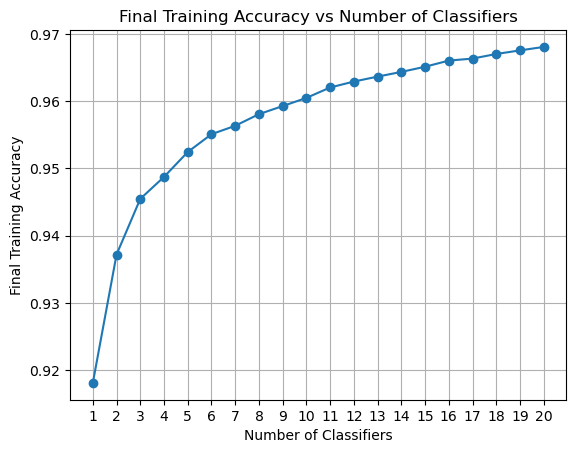

In [7]:
num_classifier = 20
samples_ft = np.ones((num_classifier, num_samples),dtype=bool)
weights = np.ones((num_classifier+1, num_samples))
weights[1,:] = np.ones(num_samples) / num_samples
num_correct = []
num_incorrect = []
epsilon = []
alpha = []
final_train_accuracy = []
final_test_accuracy = []
classifiers = []  # 存储每个分类器
final_combined_output = np.zeros((num_samples, 10))  # 初始化最终组合输出
final_train_accuracy_list = []

nn = SimpleNeuralNetwork(layer_sizes, learning_rate=learning_rate, batch_size= batch_size)

# 训练循环
for i in range(num_classifier):
    print(f'------第{i+1}个分类器------')
    # 使用函数进行重采样
    probabilities = weights[i, :] / np.sum(weights[i, :])

    resampled_train_images, resampled_train_labels = weighted_resampling(train_images, train_labels, probabilities)
    train_accuracies = []  # 用于存储每轮训练的准确率
    test_accuracies = []   # 用于存储每轮测试的准确率

    for epoch in range(epoch_num):  # 进行迭代
        
        samples_ft[i,:] = nn.train(resampled_train_images, resampled_train_labels)  # 训练神经网络
        classifiers.append(nn)
        
        num_correct.append(np.count_nonzero(samples_ft[i,:]))
        num_incorrect.append(len(samples_ft[i,:]) - num_correct[-1])
        print('正确样本个数: ', num_correct[-1])
        print('错误样本个数: ', num_incorrect[-1])

        train_accuracy = nn.evaluate_accuracy(train_images, train_labels)  # 计算训练准确率
        test_accuracy = nn.evaluate_accuracy(test_images, test_labels)  # 计算测试准确率
        train_accuracies.append(train_accuracy)  # 记录训练准确率
        test_accuracies.append(test_accuracy)  # 记录测试准确率
        # print(f'Epoch {epoch + 1}/{epoch_num}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        original_samples_ft = samples_ft[i,:].copy()
        epsilon.append(1 - np.sum(weights[i,:][original_samples_ft]) / np.sum(weights[i,:]))
        print(f'当前错误率: {epsilon[-1]:.4f}')
        
        alpha.append(0.5 * np.log((1 - epsilon[-1]) / epsilon[-1]))
        samples_ft[i,:] = np.where(samples_ft[i,:], 1, -1)
        for j in range(num_samples):
            weights[i+1,j] = weights[i,j]*np.exp(alpha[-1]*samples_ft[i,j])


        final_train_accuracy.append(nn.evaluate_accuracy(train_images, train_labels))
        final_test_accuracy.append(nn.evaluate_accuracy(test_images, test_labels))

    print(f'最终训练准确率: {final_train_accuracy[-1]:.4f}')
    print(f'最终测试准确率: {final_test_accuracy[-1]:.4f}')

    predictions = classifiers[-1].predict(train_images)  # 这里假设predict返回的是softmax的输出
    final_combined_output += alpha[i] * predictions
    final_predictions = np.argmax(final_combined_output, axis=1)

    train_labels_1 = np.argmax(train_labels, axis=1)

    final_train_accuracy_1 = np.mean(final_predictions == train_labels_1)
    final_train_accuracy_list.append(final_train_accuracy_1)
    print('------------------------------------------------')
    print(f'当前Adaboost算法输出的最终准确率: {final_train_accuracy_1:.4f}')


plt.plot(range(1, num_classifier + 1), final_train_accuracy_list, marker='o')
plt.xlabel('Number of Classifiers')
plt.ylabel('Final Training Accuracy')
plt.title('Final Training Accuracy vs Number of Classifiers')
plt.xticks(range(1, num_classifier + 1))
plt.grid(True)
plt.show()
